In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from imgaug import augmenters as iaa
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [78]:
def roi(img):
    img = img[60:135, 10:, :]
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

def gaussian_blur_1(img):
    img = img[60:135, 10:, :]
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

def thresholding(img):
    img = img[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    img = cv2.resize(img, (200, 66))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)
    # Apply adaptive thresholding to enhance lane visibility
    _, thresholded = cv2.threshold(equalized, 150, 255, cv2.THRESH_BINARY)
    # # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(thresholded, (3, 3), 0)
    # expand image dimension
    expand = np.expand_dims(blurred, axis=2)
    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0
    return normalized

def adaptive_thresholding(img):
    img = img[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    img = cv2.resize(img, (200, 66))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Apply adaptive thresholding to enhance lane visibility
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY, 21, 2)
    # expand image dimension
    expand = np.expand_dims(thresholded, axis=2)
    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0
    return normalized

def hls(image):
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Apply histogram equalization on the L channel to enhance visibility in shadows
    hls_image[:, :, 1] = cv2.equalizeHist(hls_image[:, :, 1])

    # Convert back to RGB
    enhanced_image = cv2.cvtColor(hls_image, cv2.COLOR_HLS2BGR)

    return enhanced_image

def canny_edge(img):
    img = img[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    img = cv2.resize(img, (200, 66))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply histogram equalization
    # equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Apply adaptive thresholding to enhance lane visibility
    canny = cv2.Canny(blurred, 100, 300)
    # # Apply Gaussian blur to reduce noise
    # expand image dimension
    expand = np.expand_dims(canny, axis=2)
    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0
    return normalized


def shadow_removal(image):
    # Convert image to HLS color space
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Threshold the S channel to identify shadow regions
    lower_shadow = np.array([0, 100, 0], dtype=np.uint8)
    upper_shadow = np.array([255, 255, 100], dtype=np.uint8)
    shadow_mask = cv2.inRange(hls_image, lower_shadow, upper_shadow)

    # Replace shadow regions with the mean color of the non-shadow regions
    non_shadow_pixels = np.where(shadow_mask == 0)
    mean_color = np.mean(hls_image[non_shadow_pixels], axis=0)
    hls_image[shadow_mask != 0] = mean_color

    # Convert back to BGR color space
    result_image = cv2.cvtColor(hls_image, cv2.COLOR_HLS2BGR)

    return result_image

def shadow_aware_edge_detection(image):
    # Convert image to HLS color space
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Extract the S channel (Saturation) as a grayscale image
    saturation_channel = hls_image[:, :, 2]

    # Threshold the saturation channel to create a binary mask for edge detection
    _, edge_mask = cv2.threshold(saturation_channel, 50, 255, cv2.THRESH_BINARY)

    # Apply Canny edge detection using the binary mask
    edges = cv2.Canny(edge_mask, 100, 200)

    # Combine the original image with the detected edges
    result_image = cv2.bitwise_and(image, image, mask=edges)

    return result_image


def extract_white_lane(image):
    # Convert the image to the RGB color space
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define the lower and upper threshold for white color
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)

    # Create a binary mask by thresholding the image
    white_mask = cv2.inRange(rgb_image, lower_white, upper_white)

    # Apply the mask to the original image to extract the white lane lines
    white_lane_image = cv2.bitwise_and(image, image, mask=white_mask)

    return white_lane_image


def lab_channel(image):
    # Convert the image to the LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply adaptive thresholding on the L channel to handle shadows
    _, l_binary = cv2.threshold(l_channel, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Combine the binary thresholded L channel with the A and B channels
    # This will keep white lane lines and ignore shadows and other features
    binary_image = cv2.merge((l_binary, a_channel, b_channel))

    # Convert the image back to the RGB color space
    result_image = cv2.cvtColor(binary_image, cv2.COLOR_LAB2BGR)

    return result_image


def lab_extract_white_lane(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into H, S, and V channels
    h_channel, s_channel, v_channel = cv2.split(hsv_image)

    # Apply thresholding on the V channel to identify the brightest pixels
    _, v_binary = cv2.threshold(v_channel, 0, 255, cv2.THRESH_BINARY)

    # Convert the binary image to 3 channels for merging with the original image
    binary_image = cv2.merge((v_binary, v_binary, v_binary))

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_and(image, binary_image)

    return white_lane_image


def hsl_compare(image):

    # Convert the image to the HSL color space
    hsl_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    print("hsl_image shape: ",np.asarray(hsl_image).shape)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, l_channel = cv2.split(hsl_image)

    # Conditions
    condition_1 = (s_channel>=200) | (l_channel >= 200)
    condition_2 = (h_channel >= 100) & (l_channel >= 50)
    condition_3 = (h_channel >= 100) & (s_channel >= 55)
    # Create a binary mask by combining the two conditions using logical OR
    combined_1and2 = np.logical_or(condition_1, condition_2)
    combined_mask = np.logical_or(combined_1and2, condition_3) .astype(np.uint8) * 255

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_and(image, binary_image)

    return white_lane_image


def hsv_compare(image):

    # Convert the image to the HSL color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    print("hsl_image shape: ",np.asarray(hsv_image).shape)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, v_channel = cv2.split(hsv_image)
    print("h_channel shape: ",np.asarray(h_channel).shape)
    print("s_channel shape: ",np.asarray(s_channel).shape)
    print("v_channel shape: ",np.asarray(v_channel).shape)
    print("h_channel : ", h_channel)
    print("s_channel : ",np.asarray(s_channel))
    print("v_channel : ",np.asarray(v_channel))
    # Condition 1: Pixels with L channel value larger than 90
    condition_1 = ((v_channel/255)*100) >= 85
    print("condition_1 shape: ",np.asarray(condition_1).shape)
    print(condition_1)

    # Condition 2: Pixels with L channel value larger than 23 and H channel value larger than 200
    condition_2 = ((v_channel/255*100) >= 15) & (h_channel >= 200)
    print("condition_2 shape: ",np.asarray(condition_2).shape)
    print("condition_2: ",np.asarray(condition_2))

    # Create a binary mask by combining the two conditions using logical OR
    combined_mask = np.logical_or(condition_1, condition_2).astype(np.uint8) * 255
    print("combined_mask shape: ",np.asarray(combined_mask).shape)

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))
    print("binary_image shape: ",np.asarray(binary_image).shape)

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_and(image, binary_image)
    print("white_lane_image shape: ",np.asarray(white_lane_image).shape)

    return white_lane_image


def hsl_filter_3_layer(image):
    image = image[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    image = cv2.resize(image, (200, 66))

    # Convert the image to the HSL color space
    hsl_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, l_channel = cv2.split(hsl_image)

    # Conditions
    # condition_1 = (100 < h_channel < 120) & (55 < s_channel < 80) & (25 < l_channel < 45)  Dark
    condition_1 = (90<h_channel)&(h_channel< 120) & ((s_channel-l_channel)>20) & ((s_channel-l_channel)<40) & (s_channel > 60)#(55<s_channel)&(s_channel<80) & (25<l_channel)&(l_channel<55)
    # condition_2 = (20 < h_channel < 40) & (s_channel > 200) | (l_channel > 200)   Bright
    condition_2 = (15<h_channel)&(h_channel<40) & ((((s_channel-l_channel)>175) & ((s_channel-l_channel)<220)) | ((s_channel>200)&(l_channel>100)))#| (l_channel > 220)

    # Create a binary mask by combining the two conditions using logical OR
    combined_mask = np.logical_or(condition_1, condition_2).astype(np.uint8) * 255

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))

    # Reduce the saturation and lightness of original image
    s_channel = s_channel * 0.8
    l_channel = l_channel * 0.6


    reduced_image = cv2.merge((h_channel.astype(np.uint8), s_channel.astype(np.uint8), l_channel.astype(np.uint8)))

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_or(reduced_image, binary_image)


    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(white_lane_image, (5, 5), 0)

    # Normalize pixel values to [0, 1]
    normalized = blurred / 255.0

    return normalized


def hsl_filter_1_layer(image):
    image = image[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    image = cv2.resize(image, (200, 66))

    # Convert the image to the HSL color space
    hsl_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, l_channel = cv2.split(hsl_image)

    # Conditions
    # condition_1 = (100 < h_channel < 120) & (55 < s_channel < 80) & (25 < l_channel < 45)  Dark
    condition_1 = (100<h_channel)&(h_channel< 120) & (65<s_channel)&(s_channel<80) & (25<l_channel)&(l_channel<55)
    # condition_2 = (20 < h_channel < 40) & (s_channel > 200) | (l_channel > 200)   Bright
    condition_2 = (20<h_channel)&(h_channel<40) & ((s_channel-l_channel)>175) & ((s_channel-l_channel)<220) #| (l_channel > 220)

    # Create a binary mask by combining the two conditions using logical OR
    combined_mask = np.logical_or(condition_1, condition_2).astype(np.uint8) * 255

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_or(image, binary_image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(white_lane_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # expand image dimension
    expand = np.expand_dims(blurred, axis=2)

    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0

    return normalized


def hsl_filter_1_layer_enhanced(image):
    image = image[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    image = cv2.resize(image, (200, 66))

    # Convert the image to the HSL color space
    hsl_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, l_channel = cv2.split(hsl_image)

    # Conditions
    # condition_1 = (100 < h_channel < 120) & (55 < s_channel < 80) & (25 < l_channel < 45)  Dark
    condition_1 = (90<h_channel)&(h_channel< 120) & ((s_channel-l_channel)>20) & ((s_channel-l_channel)<40) & (s_channel > 60)#(55<s_channel)&(s_channel<80) & (25<l_channel)&(l_channel<55)
    # condition_2 = (20 < h_channel < 40) & (s_channel > 200) | (l_channel > 200)   Bright
    condition_2 = (15<h_channel)&(h_channel<40) & ((((s_channel-l_channel)>175) & ((s_channel-l_channel)<220)) | ((s_channel>200)&(l_channel>100)))#| (l_channel > 220)

    # Create a binary mask by combining the two conditions using logical OR
    combined_mask = np.logical_or(condition_1, condition_2).astype(np.uint8) * 255

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))

    # Reduce the saturation and lightness of original image
    s_channel = s_channel * 0.8
    l_channel = l_channel * 0.6


    reduced_image = cv2.merge((h_channel.astype(np.uint8), s_channel.astype(np.uint8), l_channel.astype(np.uint8)))

    # Apply bitwise_and to keep only the white lane lines
    white_lane_image = cv2.bitwise_or(reduced_image, binary_image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(white_lane_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # expand image dimension
    expand = np.expand_dims(blurred, axis=2)

    # Normalize pixel values to [0, 1]
    normalized = expand / 255.0

    return normalized

def hsl_filter_binary(image):
    image = image[60:135, :, :]  # Crop upper part
    # Resize the image to a consistent size
    image = cv2.resize(image, (200, 66))

    # Convert the image to the HSL color space
    hsl_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Split the HSL image into H, L, and S channels
    h_channel, s_channel, l_channel = cv2.split(hsl_image)

    # Conditions
    # condition_1 = (100 < h_channel < 120) & (55 < s_channel < 80) & (25 < l_channel < 45)  Dark
    condition_1 = (90<h_channel)&(h_channel< 120) & ((s_channel-l_channel)>20) & ((s_channel-l_channel)<40) & (s_channel > 60)#(55<s_channel)&(s_channel<80) & (25<l_channel)&(l_channel<55)
    # condition_2 = (20 < h_channel < 40) & (s_channel > 200) | (l_channel > 200)   Bright
    condition_2 = (15<h_channel)&(h_channel<40) & ((((s_channel-l_channel)>175) & ((s_channel-l_channel)<220)) | ((s_channel>200)&(l_channel>100)))#| (l_channel > 220)

    # Create a binary mask by combining the two conditions using logical OR
    combined_mask = np.logical_or(condition_1, condition_2).astype(np.uint8) * 255

    # Convert the binary mask to 3 channels for merging with the original image
    binary_image = cv2.merge((combined_mask, combined_mask, combined_mask))

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(binary_image, (5, 5), 0)

    # Normalize pixel values to [0, 1]
    normalized = blurred / 255.0

    return normalized


def preprocessing(img, type = "histogram"):

    if type == "adaptive_thresholding":
        return adaptive_thresholding(img)
    elif type == "gaussian_blur_1":
        return gaussian_blur_1(img)
    elif type == "thresholding":
        return thresholding(img)
    elif type == "canny_edge":
        return canny_edge(img)
    elif type == "hls":
        return hls(img)
    elif type == "shadow_removal":
        return shadow_removal(img)
    elif type == "shadow_aware_edge_detection":
        return shadow_aware_edge_detection(img)
    elif type == "extract_white_lane":
        return extract_white_lane(img)
    elif type == "lab_channel":
        return lab_channel(img)
    elif type == "lab_extract_white_lane":
        return lab_extract_white_lane(img)
    elif type == "hsl_compare":
        return hsl_compare(img)
    elif type == "hsv_compare":
        return hsv_compare(img)
    elif type == "hsl_filter_3_layer":
        return hsl_filter_3_layer(img)
    elif type == "hsl_filter_1_layer":
        return hsl_filter_1_layer(img)
    elif type == "hsl_filter_1_layer_enhanced":
        return hsl_filter_1_layer_enhanced(img)
    elif type == "hsl_filter_binary":
        return hsl_filter_binary(img)
    else:
        print("No such type")


<Figure size 640x480 with 0 Axes>

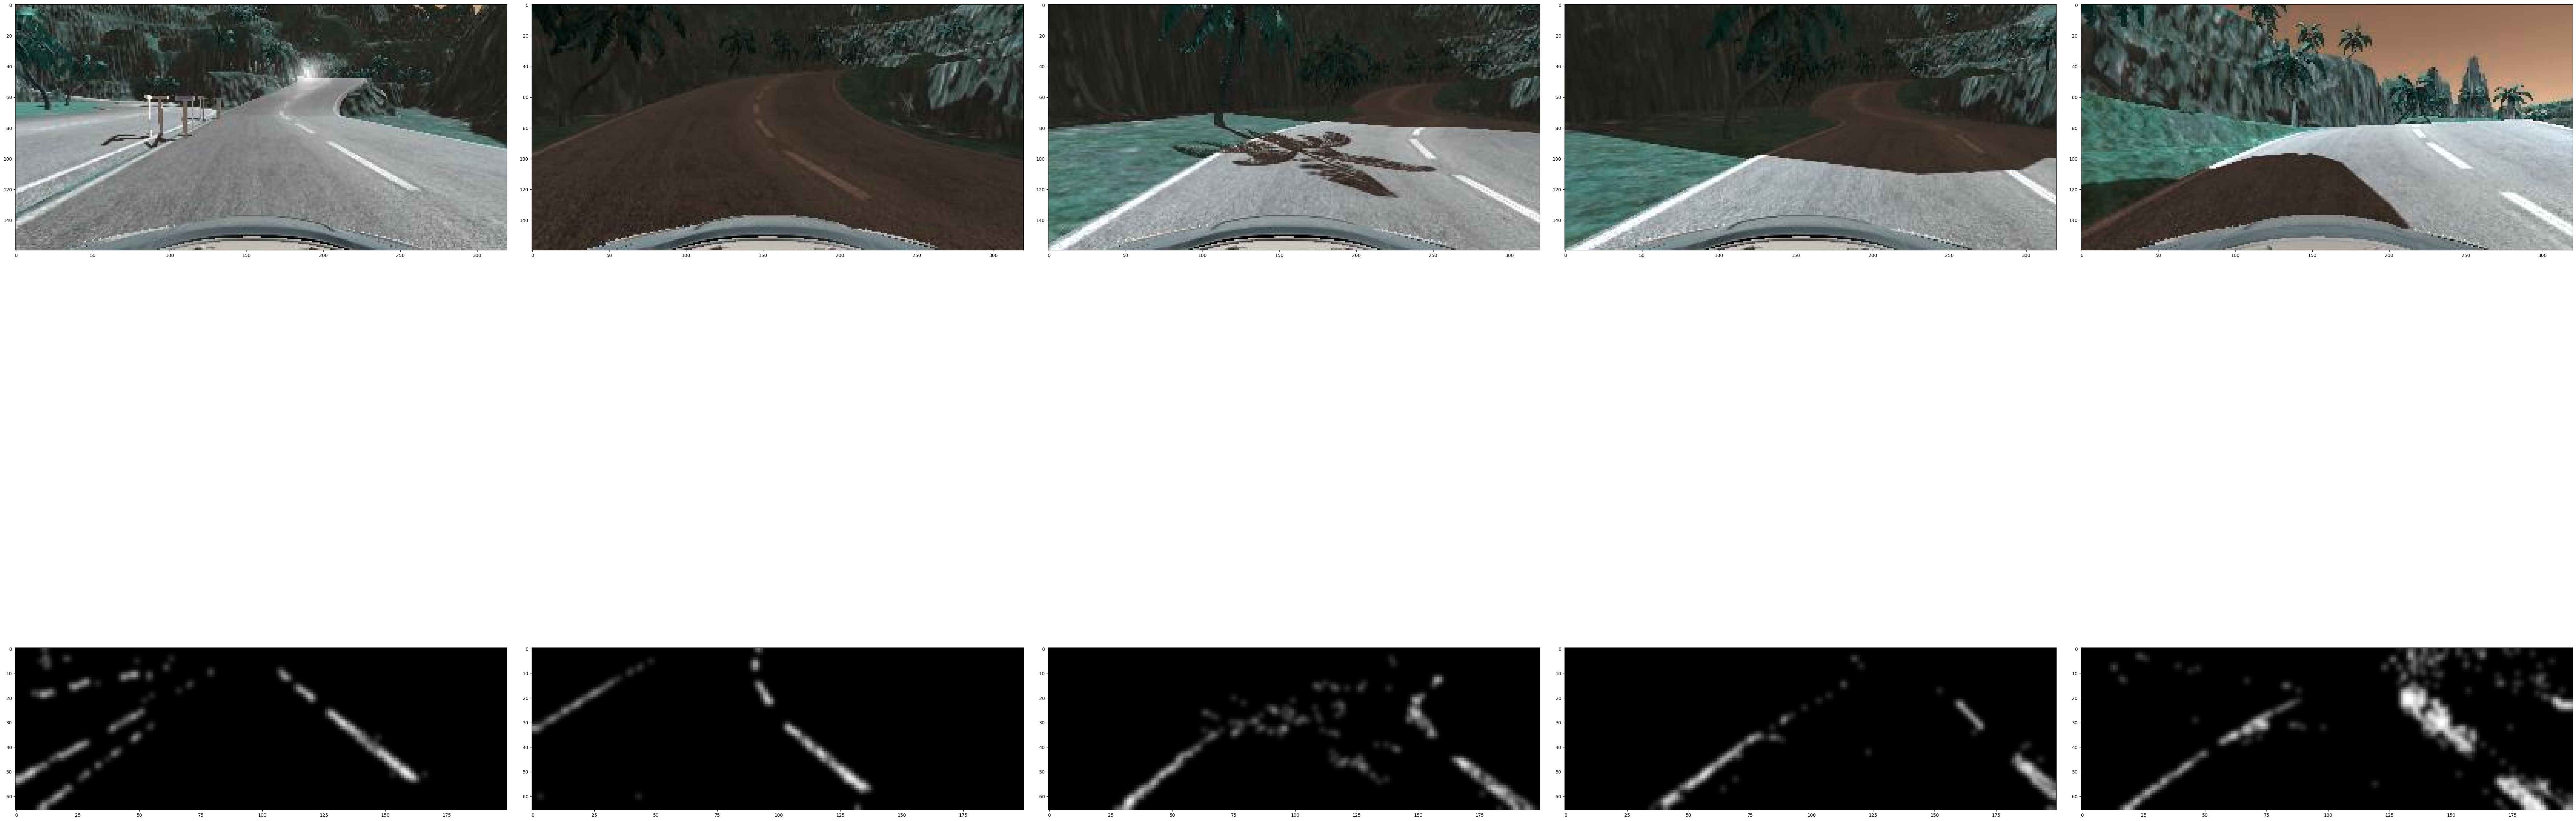

<Figure size 640x480 with 0 Axes>

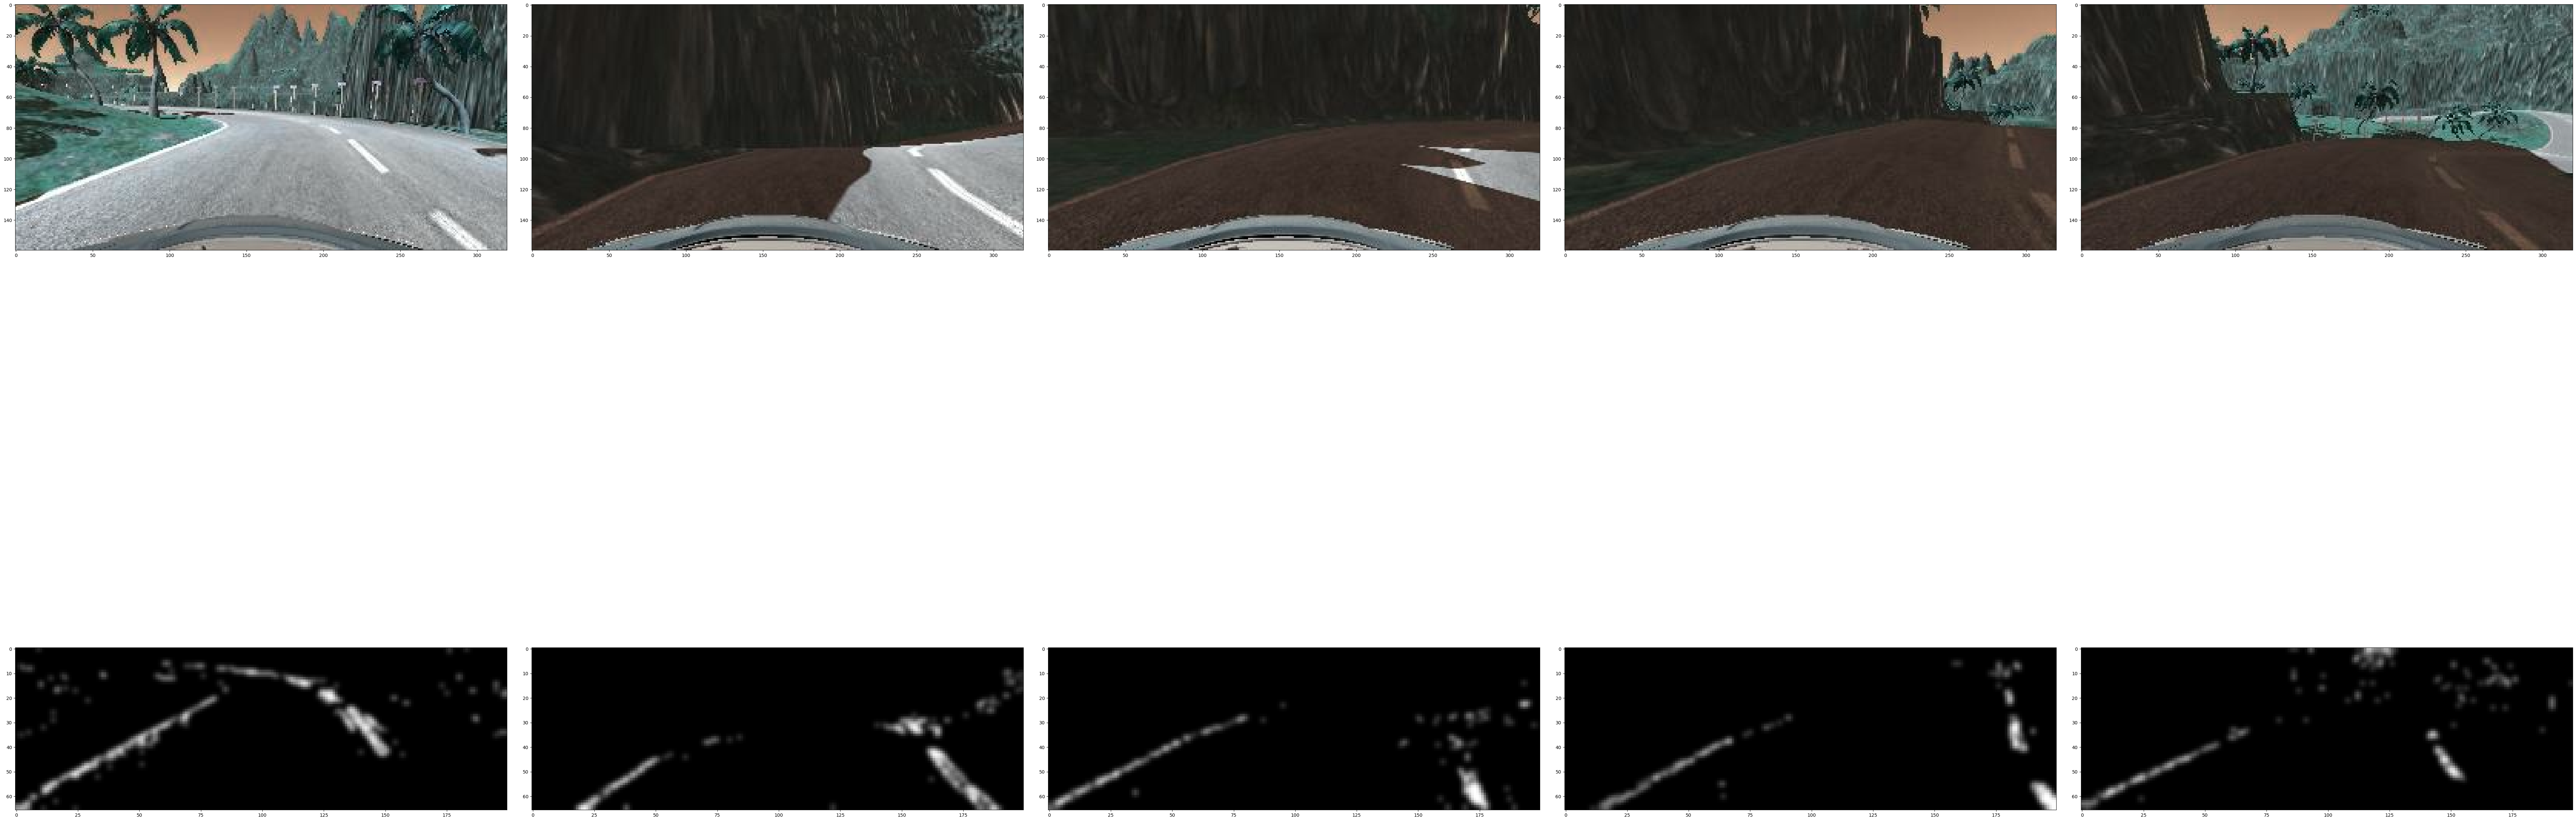

<Figure size 640x480 with 0 Axes>

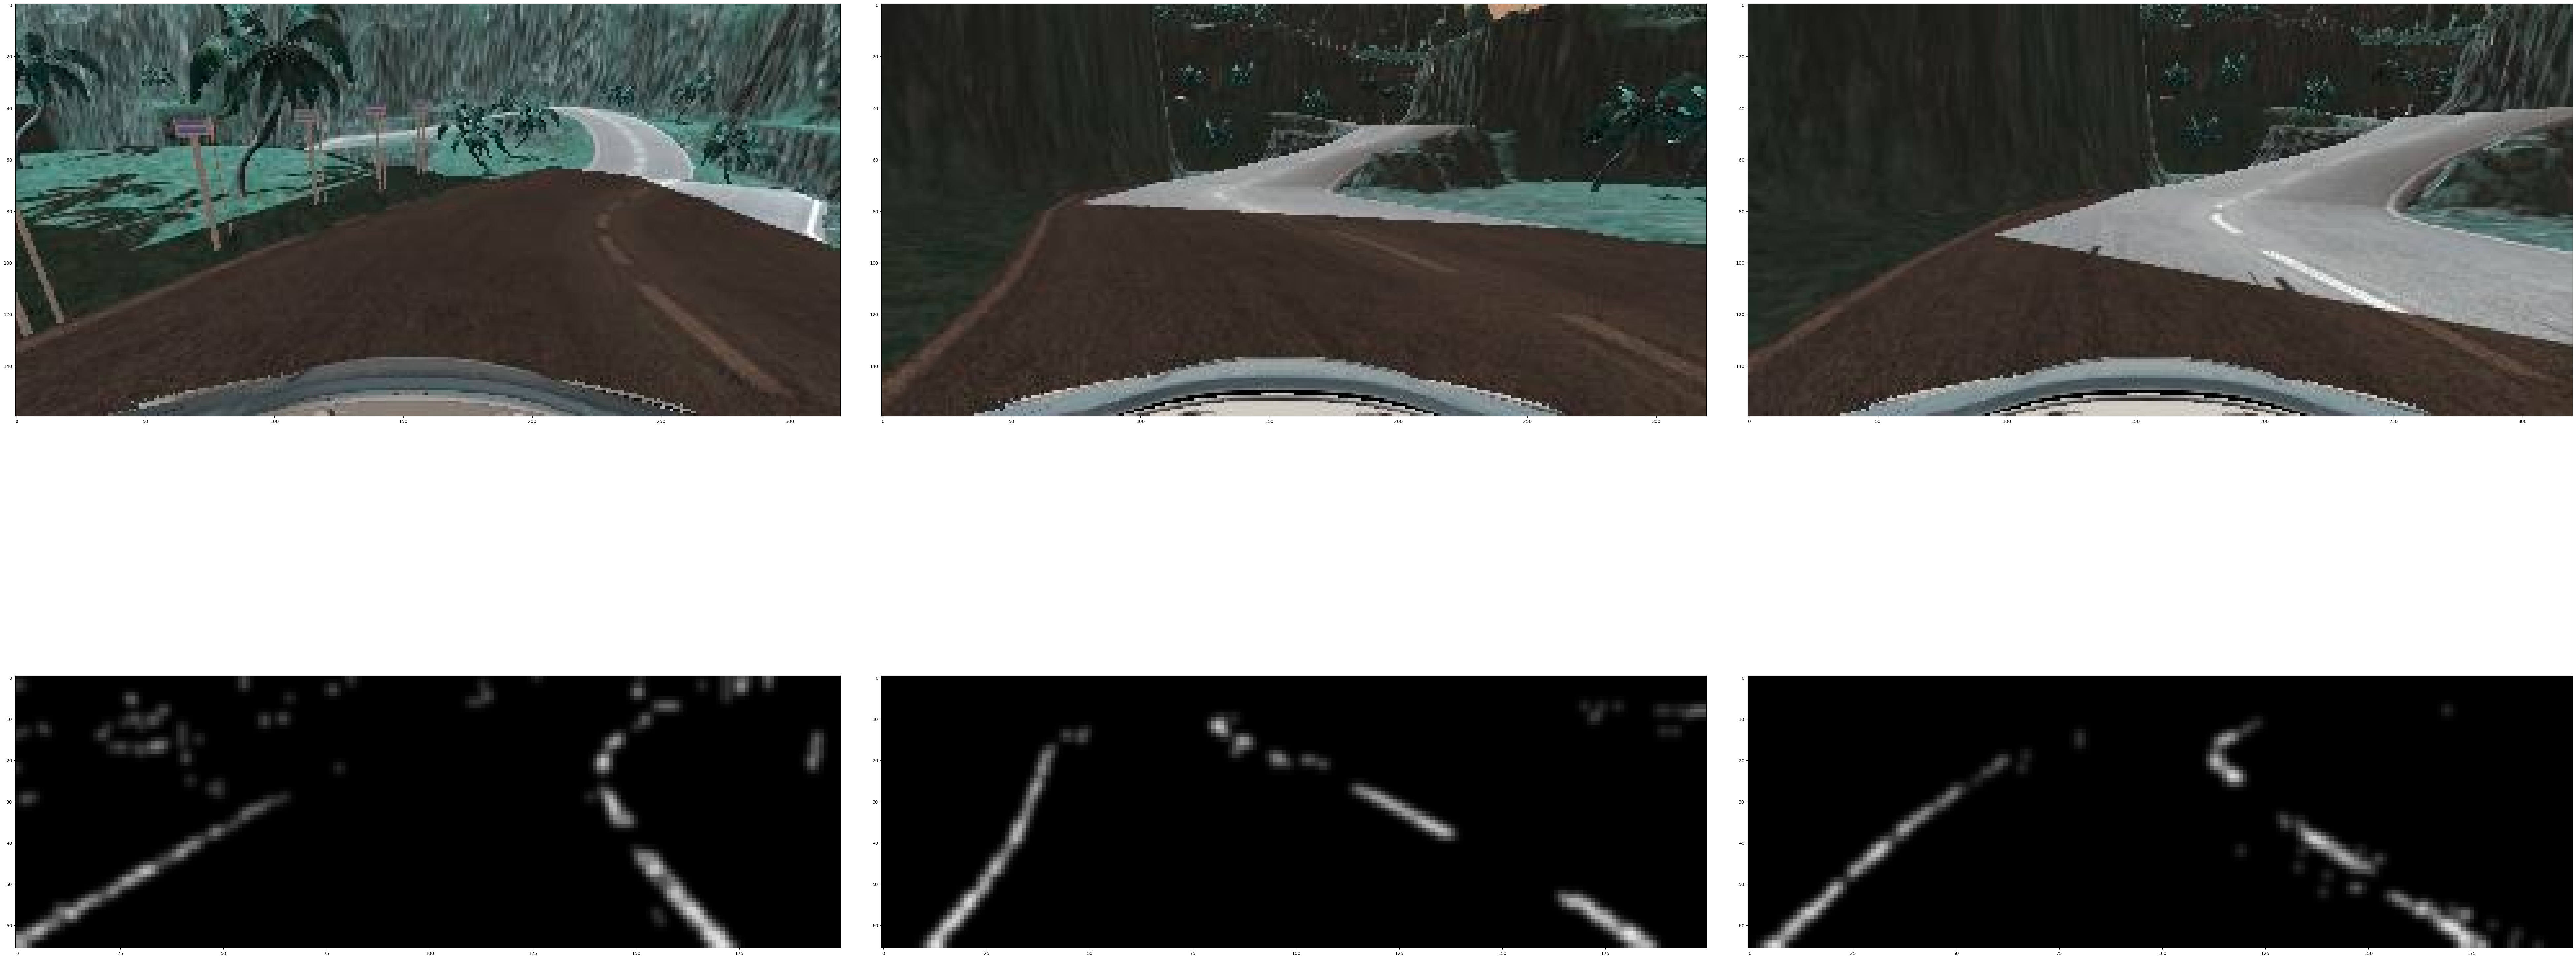

(160, 320, 3)
(66, 200, 3)


In [33]:
testImgPath = "data_test/"
testImgName = "starting_point.jpg"
testImg1 = cv2.imread(testImgPath+testImgName)
testImg2 = cv2.imread("data_test/full_shadow.jpg")
testImg3 = cv2.imread("data_test/tree_shadow.jpg")
testImg4 = cv2.imread("data_test/hill_shadow.jpg")
testImg5 = cv2.imread("data_test/uphill_shadow.jpg")
testImg6 = cv2.imread("data_test/center.jpg")   # line rgb value rgba(250,250,246,255)
testImg7 = cv2.imread("data_test/shadow1.jpg")
testImg8 = cv2.imread("data_test/shadow2.jpg")
testImg9 = cv2.imread("data_test/shadow3.jpg")
testImg10 = cv2.imread("data_test/shadow4.jpg")
testImg11 = cv2.imread("data_test/shadow5.jpg")
testImg12 = cv2.imread("data_test/shadow6.jpg")
testImg13 = cv2.imread("data_test/shadow7.jpg")
white = cv2.imread("data_test/white.png")
black = cv2.imread("data_test/black.jpg")

#plt.title("Original")
processing_type = "hsl_filter_binary"
processedImg1 = preprocessing(testImg1 ,processing_type)
processedImg2 = preprocessing(testImg2 ,processing_type)
processedImg3 = preprocessing(testImg3 ,processing_type)
processedImg4 = preprocessing(testImg4 ,processing_type)
processedImg5 = preprocessing(testImg5 ,processing_type)
processedImg6 = preprocessing(testImg6 ,processing_type)
processedImg7 = preprocessing(testImg7 ,processing_type)
processedImg8 = preprocessing(testImg8 ,processing_type)
processedImg9 = preprocessing(testImg9 ,processing_type)
processedImg10 = preprocessing(testImg10 ,processing_type)
processedImg11 = preprocessing(testImg11 ,processing_type)
processedImg12 = preprocessing(testImg12 ,processing_type)
processedImg13 = preprocessing(testImg13 ,processing_type)

original_list = [testImg1,testImg2,testImg3]
processed_list = []


plt.figure()
f, axarr = plt.subplots(2, 5, figsize=(100, 50), gridspec_kw={'height_ratios': [1, 1]})
axarr[0,0].imshow(testImg1)
axarr[0,1].imshow(testImg2)
axarr[0,2].imshow(testImg3)
axarr[0,3].imshow(testImg4)
axarr[0,4].imshow(testImg5)
axarr[1,0].imshow(processedImg1)
axarr[1,1].imshow(processedImg2)
axarr[1,2].imshow(processedImg3)
axarr[1,3].imshow(processedImg4)
axarr[1,4].imshow(processedImg5)
plt.subplots_adjust(wspace=0.05, hspace=-0.1)

plt.figure()
f, axarr = plt.subplots(2, 5, figsize=(100, 50), gridspec_kw={'height_ratios': [1, 1]})
axarr[0,0].imshow(testImg6)
axarr[0,1].imshow(testImg7)
axarr[0,2].imshow(testImg8)
axarr[0,3].imshow(testImg9)
axarr[0,4].imshow(testImg10)
axarr[1,0].imshow(processedImg6)
axarr[1,1].imshow(processedImg7)
axarr[1,2].imshow(processedImg8)
axarr[1,3].imshow(processedImg9)
axarr[1,4].imshow(processedImg10)
plt.subplots_adjust(wspace=0.05, hspace=-0.1)

plt.figure()
f, axarr = plt.subplots(2, 3, figsize=(100, 50), gridspec_kw={'height_ratios': [1, 1]})
axarr[0,0].imshow(testImg11)
axarr[0,1].imshow(testImg12)
axarr[0,2].imshow(testImg13)
axarr[1,0].imshow(processedImg11)
axarr[1,1].imshow(processedImg12)
axarr[1,2].imshow(processedImg13)
plt.subplots_adjust(wspace=0.05, hspace=-0.1)

plt.show()


print(np.asarray(testImg1).shape)
print(np.asarray(processedImg1).shape)
# plt.subplot(414)
# #plt.title("Gaussian Blur 5,5,1")
# plt.imshow(processedImg2)

In [9]:
# cv2.imshow("processedImg7",processedImg7)
# cv2.imshow("processedImg8",processedImg8)
# cv2.imshow("processedImg9",processedImg9)
# cv2.imshow("processedImg10",processedImg10)
# cv2.imshow("processedImg3", processedImg3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

<Figure size 640x480 with 0 Axes>

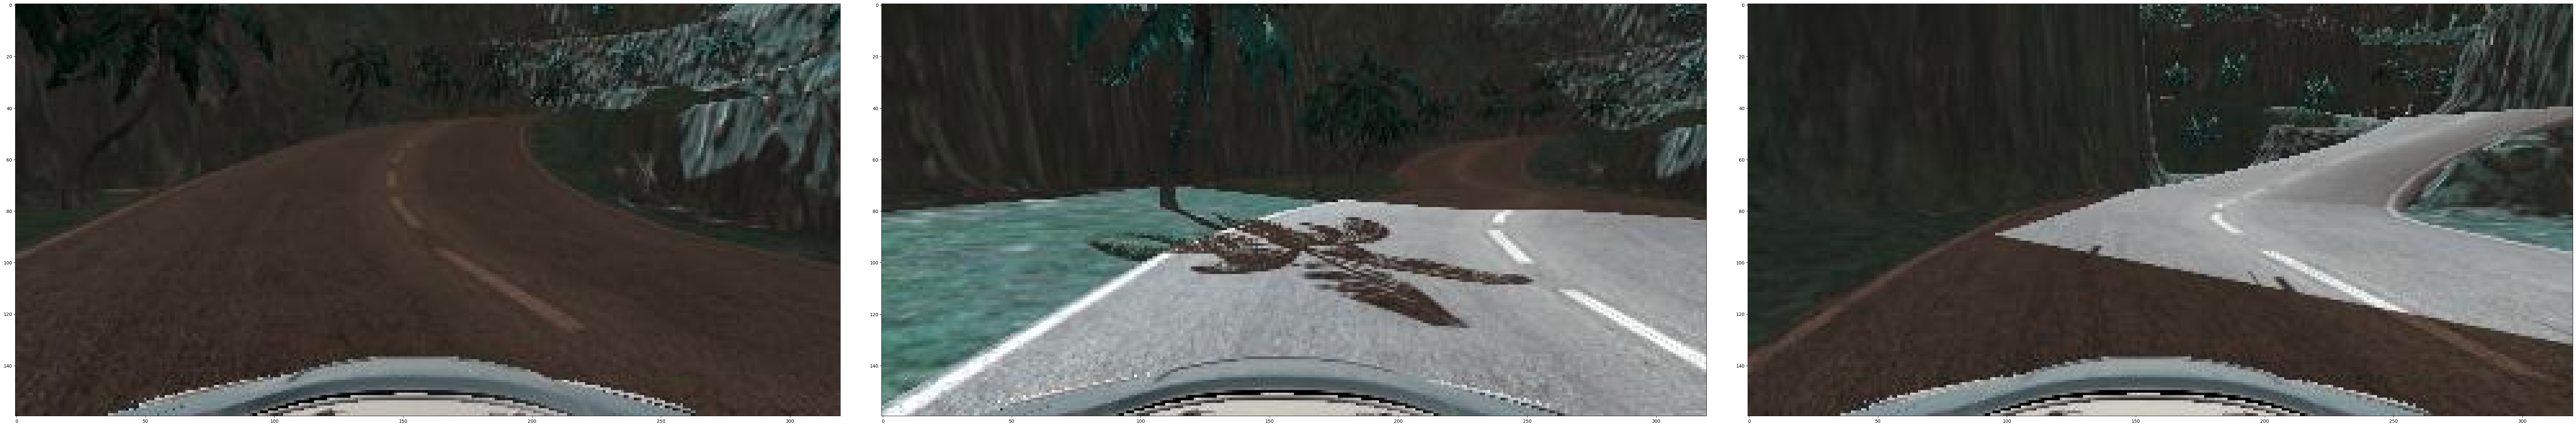

<Figure size 640x480 with 0 Axes>

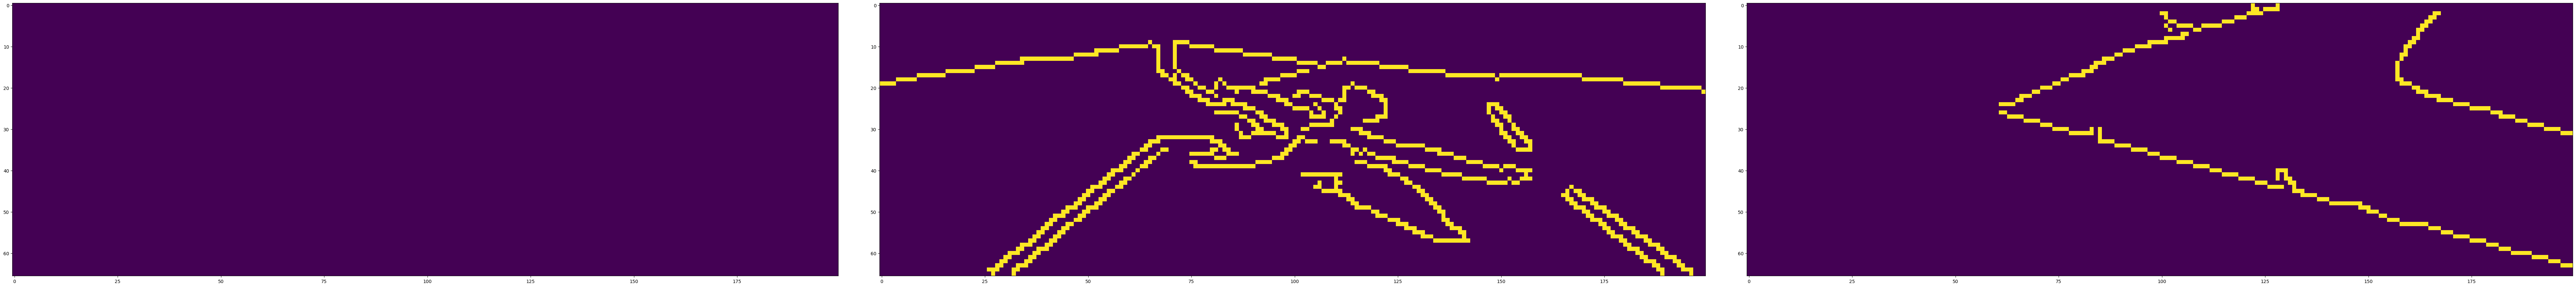

<Figure size 640x480 with 0 Axes>

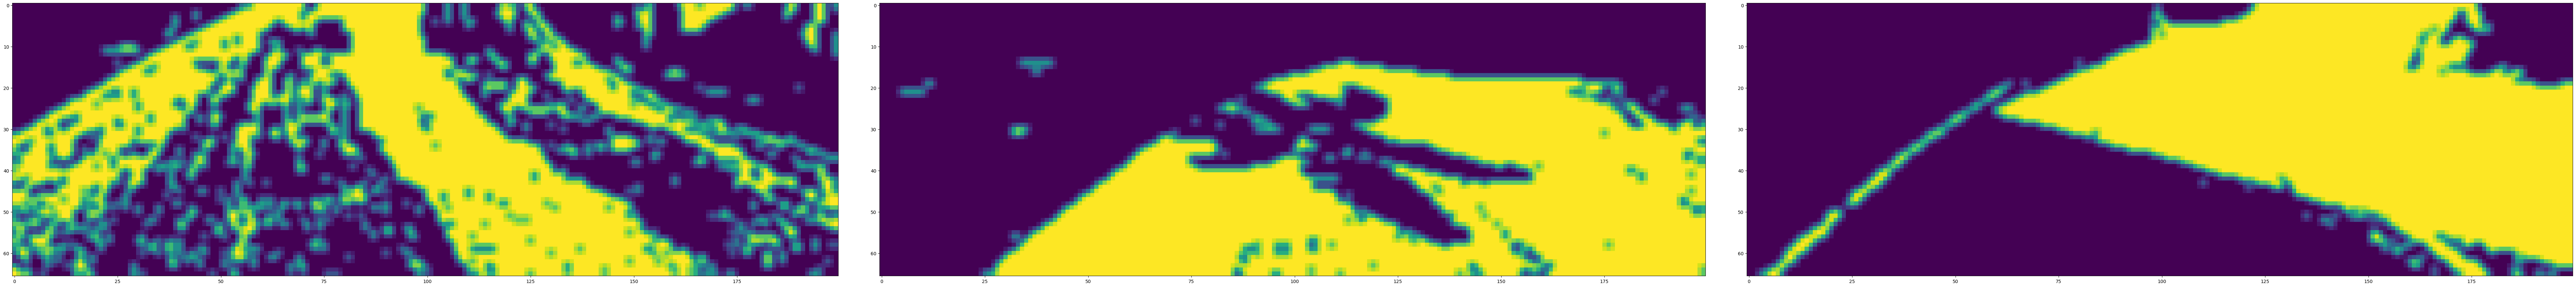

<Figure size 640x480 with 0 Axes>

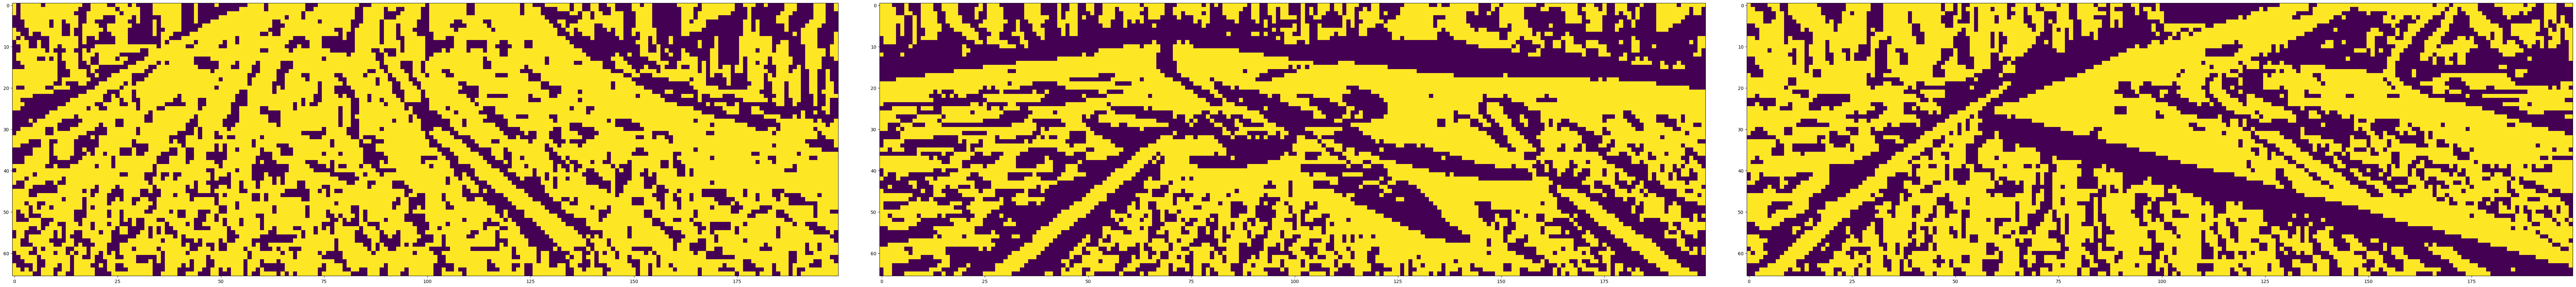

<Figure size 640x480 with 0 Axes>

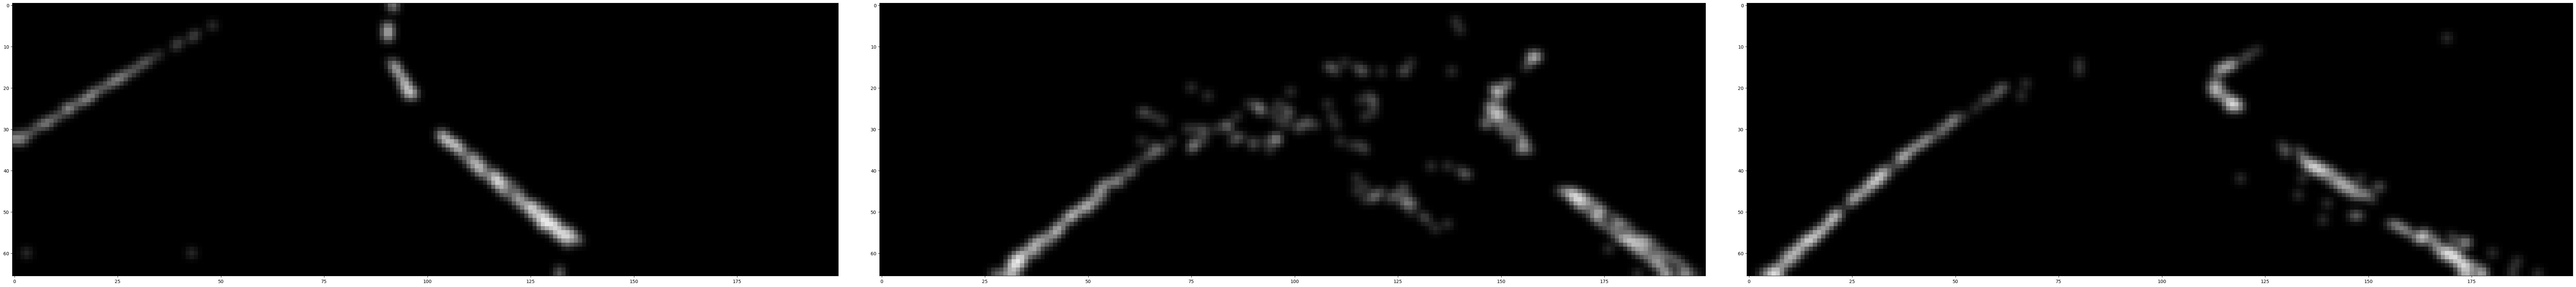

<Figure size 640x480 with 0 Axes>

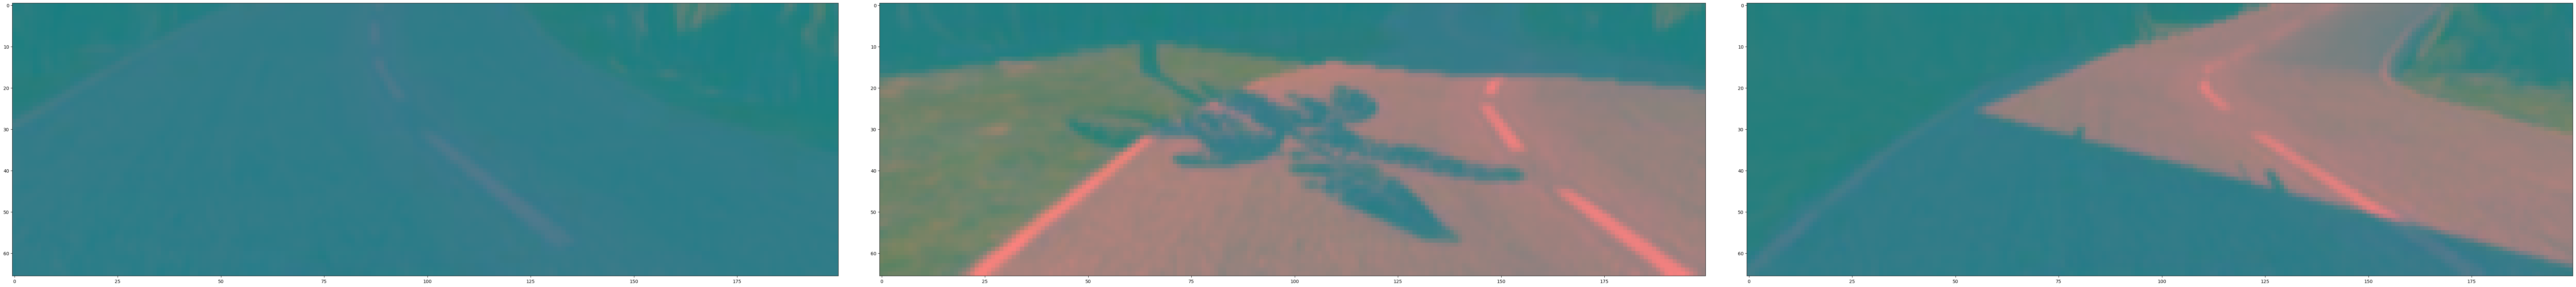

<Figure size 640x480 with 0 Axes>

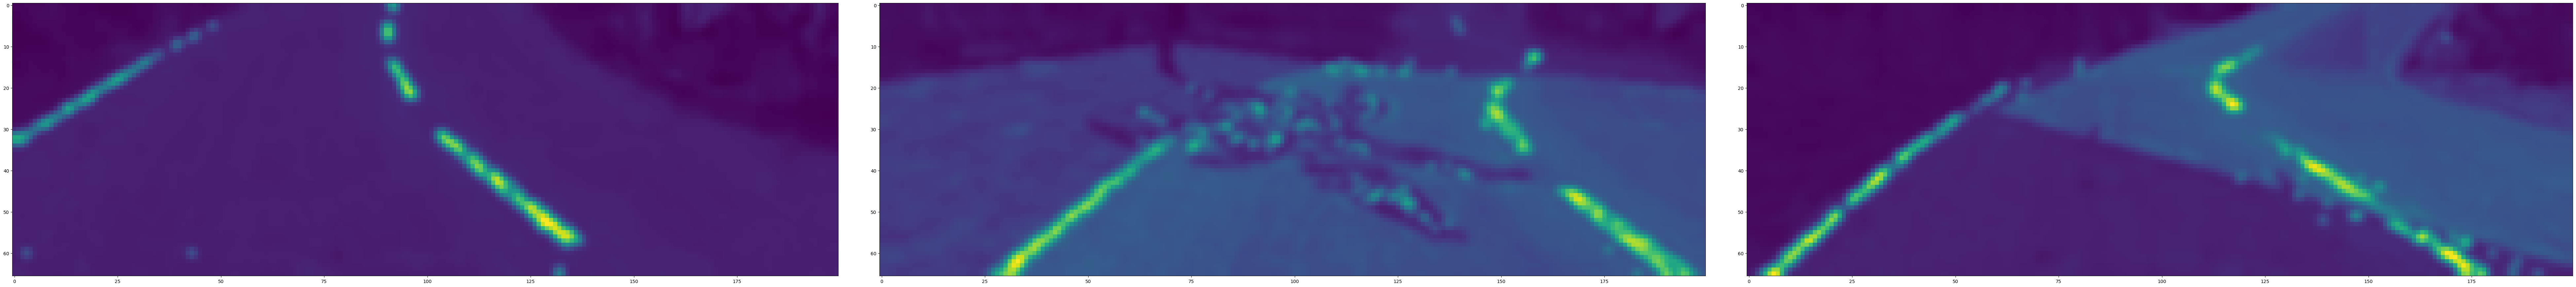

In [36]:
# Poster demo
testImg2 = cv2.imread("data_test/full_shadow.jpg")
testImg3 = cv2.imread("data_test/tree_shadow.jpg")
testImg13 = cv2.imread("data_test/shadow7.jpg")

plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(100, 50))
axarr[0].imshow(testImg2)
axarr[1].imshow(testImg3)
axarr[2].imshow(testImg13)
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(100, 50) )
axarr[0].imshow(canny_edge(testImg2))
axarr[1].imshow(canny_edge(testImg3))
axarr[2].imshow(canny_edge(testImg13))
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(100, 50) )
axarr[0].imshow(thresholding(testImg2))
axarr[1].imshow(thresholding(testImg3))
axarr[2].imshow(thresholding(testImg13))
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(100, 50) )
axarr[0].imshow(adaptive_thresholding(testImg2))
axarr[1].imshow(adaptive_thresholding(testImg3))
axarr[2].imshow(adaptive_thresholding(testImg13))
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(100, 50) )
axarr[0].imshow(hsl_filter_binary(testImg2))
axarr[1].imshow(hsl_filter_binary(testImg3))
axarr[2].imshow(hsl_filter_binary(testImg13))
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(100, 50) )
axarr[0].imshow(gaussian_blur_1(testImg2))
axarr[1].imshow(gaussian_blur_1(testImg3))
axarr[2].imshow(gaussian_blur_1(testImg13))
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(100, 50) )
axarr[0].imshow(hsl_filter_1_layer_enhanced(testImg2))
axarr[1].imshow(hsl_filter_1_layer_enhanced(testImg3))
axarr[2].imshow(hsl_filter_1_layer_enhanced(testImg13))
plt.subplots_adjust(wspace=0.05, hspace=-0.1)


(160, 320, 3)


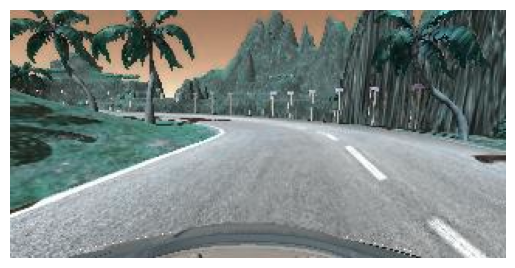

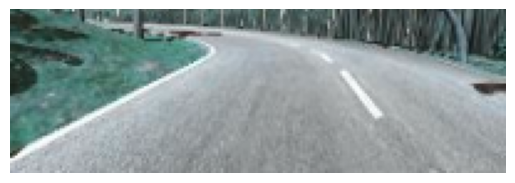

In [27]:
plt.figure()
plt.axis('off')
plt.imshow(testImg6)

print(np.asarray(testImg6).shape)

plt.figure()
plt.axis('off')
plt.imshow(roi(testImg6))

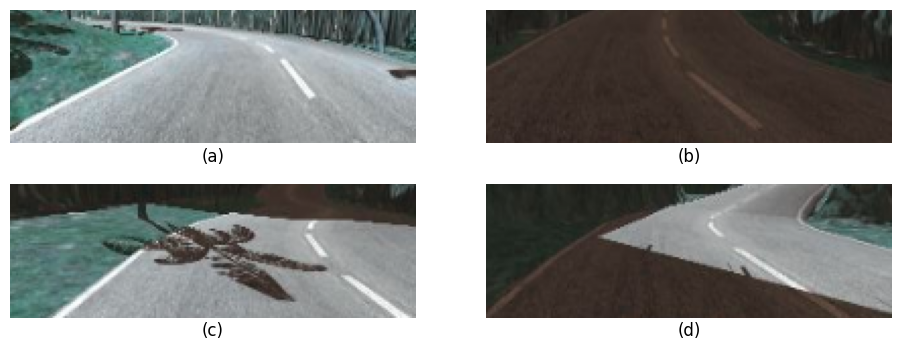

<Figure size 640x480 with 0 Axes>

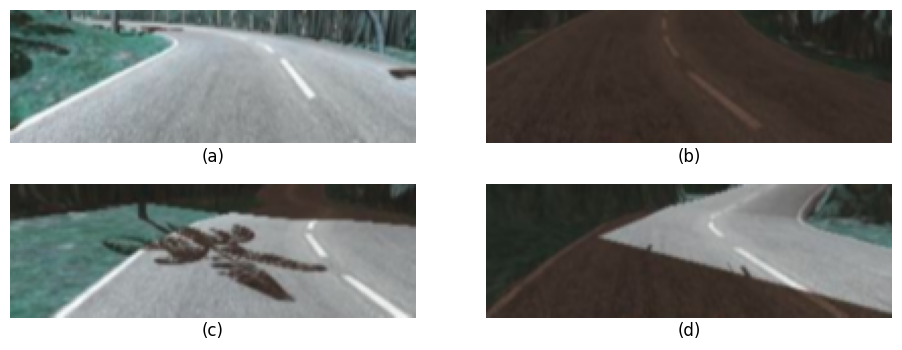

<Figure size 640x480 with 0 Axes>

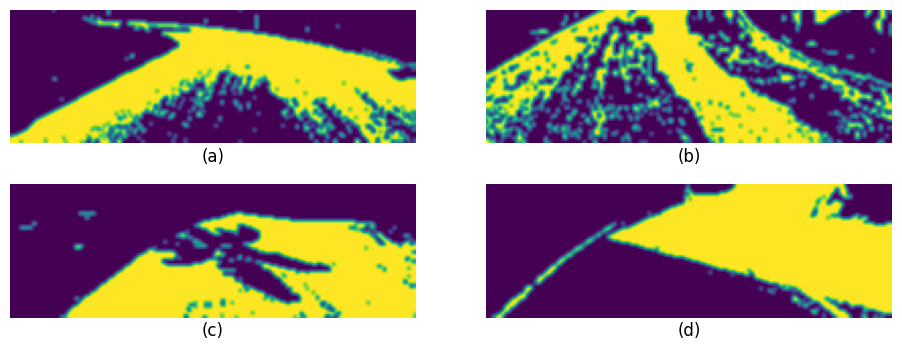

<Figure size 640x480 with 0 Axes>

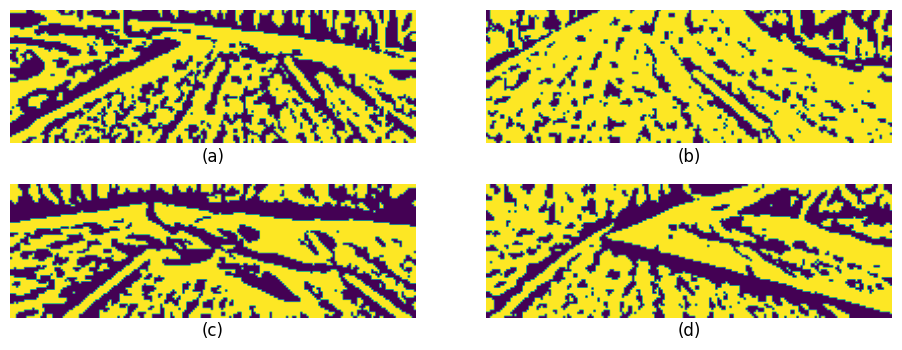

<Figure size 640x480 with 0 Axes>

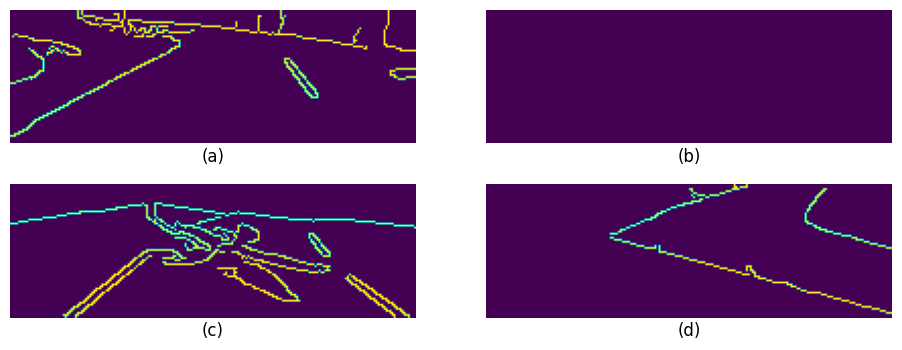

<Figure size 640x480 with 0 Axes>

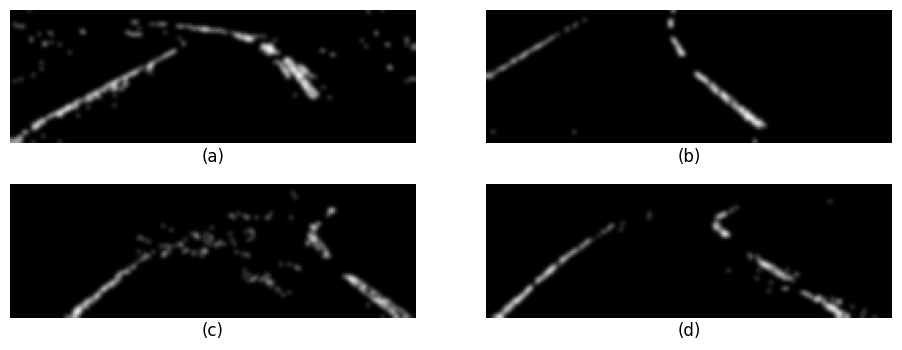

<Figure size 640x480 with 0 Axes>

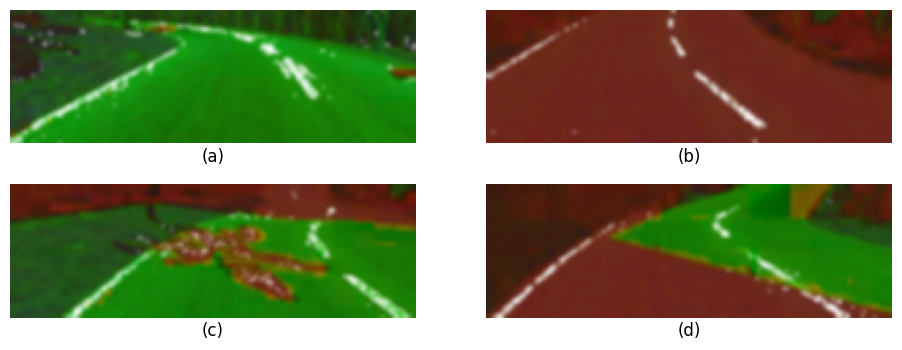

<Figure size 640x480 with 0 Axes>

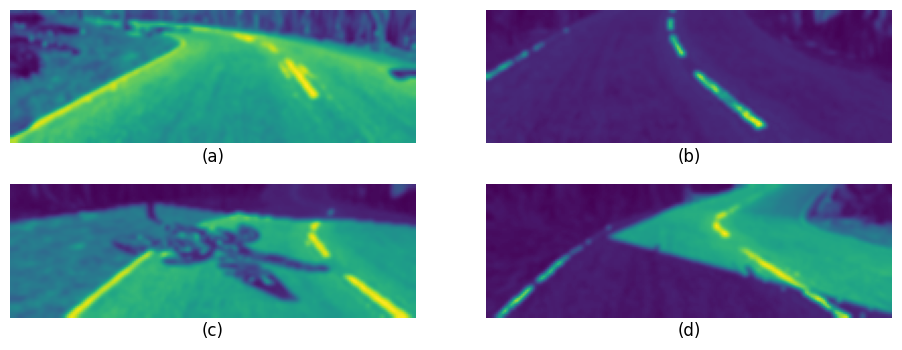

<Figure size 640x480 with 0 Axes>

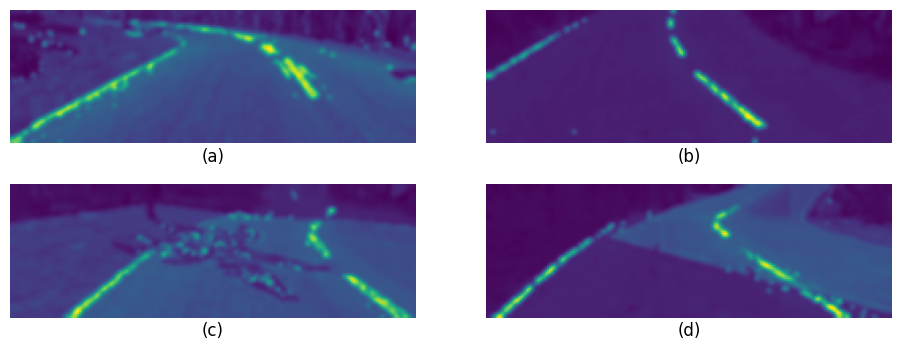

In [80]:
testImg6 = cv2.imread("data_test/center.jpg")
testImg2 = cv2.imread("data_test/full_shadow.jpg")
testImg3 = cv2.imread("data_test/tree_shadow.jpg")
testImg13 = cv2.imread("data_test/shadow7.jpg")

f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(roi(testImg6))
axarr[0][1].imshow(roi(testImg2))
axarr[1][0].imshow(roi(testImg3))
axarr[1][1].imshow(roi(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(gaussian_blur_1(testImg6))
axarr[0][1].imshow(gaussian_blur_1(testImg2))
axarr[1][0].imshow(gaussian_blur_1(testImg3))
axarr[1][1].imshow(gaussian_blur_1(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(thresholding(testImg6))
axarr[0][1].imshow(thresholding(testImg2))
axarr[1][0].imshow(thresholding(testImg3))
axarr[1][1].imshow(thresholding(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(adaptive_thresholding(testImg6))
axarr[0][1].imshow(adaptive_thresholding(testImg2))
axarr[1][0].imshow(adaptive_thresholding(testImg3))
axarr[1][1].imshow(adaptive_thresholding(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(canny_edge(testImg6))
axarr[0][1].imshow(canny_edge(testImg2))
axarr[1][0].imshow(canny_edge(testImg3))
axarr[1][1].imshow(canny_edge(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(hsl_filter_binary(testImg6))
axarr[0][1].imshow(hsl_filter_binary(testImg2))
axarr[1][0].imshow(hsl_filter_binary(testImg3))
axarr[1][1].imshow(hsl_filter_binary(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(hsl_filter_3_layer(testImg6))
axarr[0][1].imshow(hsl_filter_3_layer(testImg2))
axarr[1][0].imshow(hsl_filter_3_layer(testImg3))
axarr[1][1].imshow(hsl_filter_3_layer(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(hsl_filter_1_layer(testImg6))
axarr[0][1].imshow(hsl_filter_1_layer(testImg2))
axarr[1][0].imshow(hsl_filter_1_layer(testImg3))
axarr[1][1].imshow(hsl_filter_1_layer(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.figure()
f, axarr = plt.subplots(2, 2,figsize=(12,4))
axarr[0][0].imshow(hsl_filter_1_layer_enhanced(testImg6))
axarr[0][1].imshow(hsl_filter_1_layer_enhanced(testImg2))
axarr[1][0].imshow(hsl_filter_1_layer_enhanced(testImg3))
axarr[1][1].imshow(hsl_filter_1_layer_enhanced(testImg13))
axarr[0][0].axis('off')
axarr[0][0].set_title("(a)", y=-0.2)
axarr[0][1].axis('off')
axarr[0][1].set_title("(b)", y=-0.2)
axarr[1][0].axis('off')
axarr[1][0].set_title("(c)", y=-0.2)
axarr[1][1].axis('off')
axarr[1][1].set_title("(d)", y=-0.2)
plt.subplots_adjust(wspace=0.05, hspace=0.3)
